In [88]:
import numpy as np
from joblib import load
from pathlib import Path
from xspec import AllModels, AllData, Model, Plot
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt

from modules.network import r_squared


Model TBabs<1>(rdblur<2>*rfxconv<3>*comptb<4> + diskbb<5> + comptb<6>) Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    1.00000      +/-  0.0          
   2    2   rdblur     Betor10             -2.00000     frozen
   3    2   rdblur     Rin_M               10.0000      frozen
   4    2   rdblur     Rout_M              1000.00      frozen
   5    2   rdblur     Incl       deg      30.0000      +/-  0.0          
   6    3   rfxconv    rel_refl            -1.00000     +/-  0.0          
   7    3   rfxconv    redshift            0.0          frozen
   8    3   rfxconv    Fe_abund            1.00000      frozen
   9    3   rfxconv    cosIncl             0.500000     frozen
  10    3   rfxconv    log_xi              1.00000      +/-  0.0          
  11    4   comptb     kTs        keV      1.00000      +/-  0.0          
  12    4   comptb     gamma               3.00000      frozen
  13    4   comptb     al

Text(0.5, 0, 'Energy (KeV)')

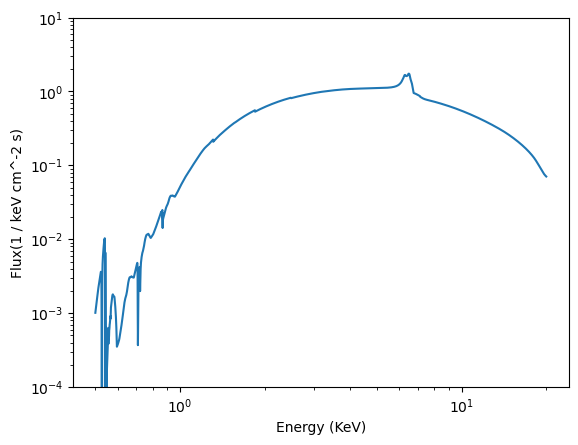

In [89]:
# Clear existing XSPEC models and data
AllModels.clear()
AllData.clear()
AllData.dummyrsp(0.5 ,20.)

# Create the model
model_name = "TBabs*(rdblur*rfxconv*comptb + diskbb + comptb)"
true_model = Model(model_name)

# Changing default frozen parameters to unfrozen
true_model.rdblur.Betor10.frozen = False
true_model.rdblur.Rout_M.frozen = True
true_model.rdblur.Rin_M.frozen = False
true_model.rfxconv.Fe_abund.frozen = False
true_model.comptb.gamma.frozen = True
true_model.comptb.delta.frozen = True
true_model.comptb.log_A.frozen = True

true_model.rdblur.Rout_M.values = 1000
true_model.comptb.delta.values = 0
true_model.comptb.log_A.values = 8

true_model.comptb.kTe.values = 500
true_model.comptb.kTs.values = 2

# Linking the parameters
true_model.rfxconv.cosIncl.link = "COSD(5)"

start = 20  # Number of the first parameter of comptb_6
for i in range(start, start + len(true_model.comptb_6.parameterNames)):
    true_model(i).link = true_model(i-9) # 9 is the separation between comptb and comptb_6

# Collect the relevant parameter (the ones not frozen or linked)
relevant_par = []
relevant_val = []
for n_par in range(1, true_model.nParameters + 1):
    if not true_model(n_par).frozen and not true_model(n_par).link:
        relevant_val.append(true_model(n_par).values[0])
        relevant_par.append(n_par)

true_model.show()

# Set up the energy range of interest for plotting
Plot.device = "/null"
Plot.xAxis = "keV"
Plot.show()
Plot('model')
energy = Plot.x()
true_flux = Plot.model()

plt.plot(energy, true_flux)
plt.xscale("log")
plt.yscale("log")
plt.ylim(1.e-4, 1.e1)
plt.ylabel("Flux(1 / keV cm^-2 s)")
plt.xlabel("Energy (KeV)")


In [90]:
for n_par in range(1, true_model.nParameters + 1):
    if not true_model(n_par).frozen and not true_model(n_par).link:
        print(true_model(n_par).values)


[1.0, 0.01, 0.0, 0.0, 100000.0, 1000000.0]
[-2.0, 0.02, -10.0, -10.0, 20.0, 20.0]
[10.0, 0.1, 6.0, 6.0, 1000.0, 10000.0]
[30.0, 0.3, 0.0, 0.0, 90.0, 90.0]
[-1.0, 0.01, -1.0, -1.0, 1000000.0, 1000000.0]
[1.0, 0.01, 0.5, 0.5, 3.0, 3.0]
[1.0, 0.01, 1.0, 1.0, 6.0, 6.0]
[2.0, 0.02, 0.1, 0.1, 10.0, 10.0]
[2.0, 0.02, 0.0, 0.0, 400.0, 400.0]
[500.0, 5.0, 0.2, 0.2, 2000.0, 2000.0]
[1.0, 0.01, 0.0, 0.0, 1e+20, 1e+24]
[1.0, 0.01, 0.0, 0.0, 1000.0, 1000.0]
[1.0, 0.01, 0.0, 0.0, 1e+20, 1e+24]


In [91]:
path_to_logs = Path(Path.cwd() / 'logs')
log_dir = path_to_logs / 'fit' / 'ANN' / 'drop_0.3' /'lr_1e-4' / 'ANN_256x6_150e_15k'
model_file_path = log_dir / 'my_model.h5'

# Load the model
model = load_model(model_file_path, custom_objects={'r_squared': r_squared})
# Load the saved scaler
X_scaler = load(log_dir / 'X_scaler.joblib')
X_new_scaled = X_scaler.transform([true_flux])

# Make predictions
prediction = model.predict(X_new_scaled)
# Load the scalers
loaded_scalers = {}
parameters = []
for i in range(prediction.shape[1]):
    loaded_scalers[i] = load(log_dir / f'scaler_{i}.joblib')
    parameters.append(loaded_scalers[i].inverse_transform(prediction[0][i].reshape(-1,1)))
# Extracting the single float value from each sub-array
par = np.array([arr[0, 0] for arr in parameters]).astype(float)
log_index = [0, 2, 12]
for i in log_index:
    par[i] =  pow(10, par[i])

1/1 [==============================] - 0s 73ms/step



Model TBabs<1>(rdblur<2>*rfxconv<3>*comptb<4> + diskbb<5> + comptb<6>) Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    1.00000      +/-  0.0          
   2    2   rdblur     Betor10             -2.00000     frozen
   3    2   rdblur     Rin_M               10.0000      frozen
   4    2   rdblur     Rout_M              1000.00      frozen
   5    2   rdblur     Incl       deg      30.0000      +/-  0.0          
   6    3   rfxconv    rel_refl            -1.00000     +/-  0.0          
   7    3   rfxconv    redshift            0.0          frozen
   8    3   rfxconv    Fe_abund            1.00000      frozen
   9    3   rfxconv    cosIncl             0.500000     frozen
  10    3   rfxconv    log_xi              1.00000      +/-  0.0          
  11    4   comptb     kTs        keV      1.00000      +/-  0.0          
  12    4   comptb     gamma               3.00000      frozen
  13    4   comptb     al

Text(0.5, 0, 'Energy (KeV)')

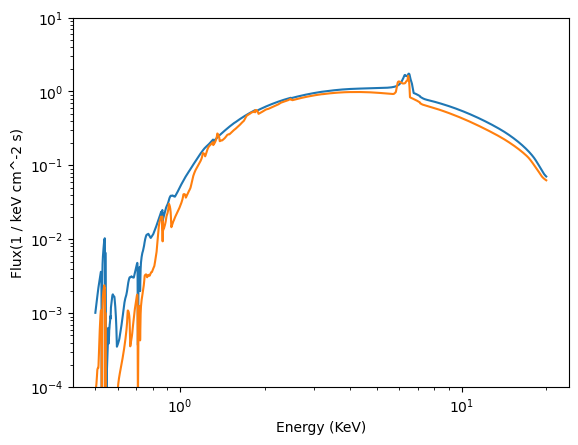

In [92]:
# Clear existing XSPEC models and data
AllModels.clear()
AllData.clear()
AllData.dummyrsp(0.5 ,20.)

# Create the model
model_name = "TBabs*(rdblur*rfxconv*comptb + diskbb + comptb)"
# Initialize the model with the scaled parameters
#m = Model(model_name)
m = Model(model_name, setPars={int(relevant_par[j]):par[j] for j in range(len(relevant_par))})

# Changing default frozen parameters to unfrozen
m.rdblur.Betor10.frozen = False
m.rdblur.Rout_M.frozen = True
m.rdblur.Rin_M.frozen = False
m.rfxconv.Fe_abund.frozen = False
m.comptb.gamma.frozen = True
m.comptb.delta.frozen = True
m.comptb.log_A.frozen = True

m.rdblur.Rout_M.values = 1000
m.comptb.log_A.values = 8

m.comptb.delta.values = 0

'''
#m(1).values = par[0]
m(2).values = 0#par[1]
m(3).values = 20#par[2]
m(5).values = 60#par[3]
#m(6).values = par[4]
#m(8).values = par[5]
#m(10).values = par[6]
#m(11).values = 5#par[7]
#m(13).values = par[8]
m(15).values = 10#par[9]
#m(17).values = par[10]
#m(18).values = par[11]
#m(19).values = par[12]
'''
m.rfxconv.cosIncl.link = "COSD(5)"
# Linking comptb_6 (refletion) parameters to comptb (comptb)
start = 20  # Number of the first parameter of comptb_6
for i in range(start, start + len(m.comptb_6.parameterNames)):
    m(i).link = m(i-9) # 9 is the separation between comptb and comptb_6

# Add the model to the spectral analysis system
AllModels.setPars(m)

# Set up the energy range of interest for plotting
Plot.device = "/null"
Plot.xAxis = "keV"
Plot.show()
Plot('model')
m_energy = Plot.x()
m_flux = Plot.model()

plt.plot(energy, true_flux, label="True")
plt.plot(m_energy, m_flux, label="Model")
plt.xscale("log")
plt.yscale("log")
plt.ylim(1.e-4, 1.e1)
plt.ylabel("Flux(1 / keV cm^-2 s)")
plt.xlabel("Energy (KeV)")

(-6.0, 3.0)

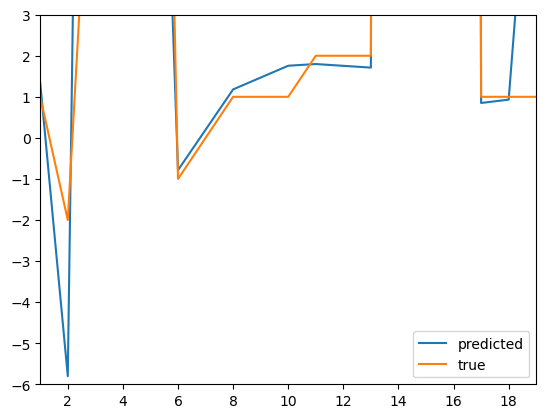

In [102]:
plt.plot(relevant_par, par, label="predicted")
plt.plot(relevant_par, relevant_val, label="true")
plt.legend()
plt.xlim(1, 19)
#plt.ylim(-6, 3)

In [94]:
m(19).values

[9.517278191188774, 0.09517278191188774, 0.0, 0.0, 1e+20, 1e+24]

In [95]:
m.show()


Model TBabs<1>(rdblur<2>*rfxconv<3>*comptb<4> + diskbb<5> + comptb<6>) Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    1.34113      +/-  0.0          
   2    2   rdblur     Betor10             -5.80193     +/-  0.0          
   3    2   rdblur     Rin_M               41.8946      +/-  0.0          
   4    2   rdblur     Rout_M              1000.00      frozen
   5    2   rdblur     Incl       deg      18.2063      +/-  0.0          
   6    3   rfxconv    rel_refl            -0.785352    +/-  0.0          
   7    3   rfxconv    redshift            0.0          frozen
   8    3   rfxconv    Fe_abund            1.18043      +/-  0.0          
   9    3   rfxconv    cosIncl             0.949938     = COSD(p5)
  10    3   rfxconv    log_xi              1.75686      +/-  0.0          
  11    4   comptb     kTs        keV      1.79818      +/-  0.0          
  12    4   comptb     gamma               3.000